# AdaBoost

AdaBoost是集成学习算法的一种，属于boosting，它的特点是序列化串行叠加基分类器，另外还有并行的bagging方法。
> 优点：泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整。<br>
> 缺点：对离群点敏感。<br>
> 适用数据类型：数值型和标称型。<br>

AdaBoost的一般流程：
> 1. 收集数据:可以使用任意方法。
> 2. 准备数据:依赖于所使用的弱分类器类型,本章使用的是单层决策树,这种分类器可以处理任何数据类型。当然也可以使用任意分类器作为弱分类器,第2章到第6章中的任一分类器都可以充当弱分类器。作为弱分类器,简单分类器的效果更好。
> 3. 分析数据:可以使用任意方法。
> 4. 训练算法:AdaBoost的大部分时间都用在训练上,分类器将多次在同一数据集上训练弱分类器。
> 5. 测试算法:计算分类的错误率。
> 6. 使用算法:同SVM一样,AdaBoost预测两个类别中的一个。如果想把它应用到多个类别的场合,那么就要像多类SVM中的做法一样对AdaBoost进行修改。

AdaBoost运行过程如下:训练数据中的每个样本,并赋予其一个权重,这些权重构成了向量$D$。一开始,这些权重都初始化成相等值。首先在训练数据上训练出一个弱分类器并计算该分类器的错误率,然后在同一数据集上再次训练弱分类器。在分类器的第二次训练当中,将会重新调整每个样本的权重,其中第一次分对的样本的权重将会降低,而第一次分错的样本的权重将会提高。为了从所有弱分类器中得到最终的分类结果,AdaBoost为每个分类器都分配了一个权重值alpha,这些alpha值是基于每个弱分类器的错误率进行计算的。其中,错误率ε的定义为:
$$\epsilon=\frac{未正确分类的样本}{正确分类的样本}$$
alpha的计算公式如下：
$$\alpha=\frac12\ln(\frac{1-\epsilon}{\epsilon})$$
计算出alpha值后，可以对权重向量$D$进行更新：<br>
如果样本被正确分类，那么样本权重为：
$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{-\alpha}}{Sum(D)}$$
如果样本被错误分类，那么样本权重为：
$$D_i^{(t+1)}=\frac{D_i^{(t)}e^{\alpha}}{Sum(D)}$$
计算出$D$后，AdaBoost继续迭代，不断重复训练和调整权重，直到满足停机条件。

In [91]:
import numpy as np
import matplotlib.pyplot as plt

## 1. 基于单层决策树构建弱分类器
单层决策树也成为决策树桩，它仅基于单个特征来做决策，相当于决策树中的一个结点。

In [76]:
def loadSimpData():
    datMat = np.matrix([[1., 2.1],
                         [2., 1.1],
                         [1.3, 1.],
                         [1., 1.],
                         [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [77]:
datMat, classLabels = loadSimpData()
datMat, classLabels

(matrix([[1. , 2.1],
         [2. , 1.1],
         [1.3, 1. ],
         [1. , 1. ],
         [2. , 1. ]]), [1.0, 1.0, -1.0, -1.0, 1.0])

下面第一个函数，

In [78]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    """
    将数据集按照特征进行二分类
    
    Parameters
    -----------
    threshVal : 特征的阈值
    threshIneq : 特征小于阈值的在左结点
    """
    
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        # 开始在这里出现了问题，最后值写成了1.0，导致算法一直无法收敛。修改为-1.0正常收敛
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

def buildStump(dataArr, classLabels, D):
    """单层决策树生成
    
    Parameters
    -----------
    dataArr : 输入样本
    classLabels : 样本标签
    D : 样本权重向量
    """
    
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m, n = dataMatrix.shape
    # numSteps：在特征所有可能的值上进行遍历，对特征的取值进行切分
    # bestStump：用于存储最佳决策树桩
    numSteps = 10.0
    bestStump = {}
    bestClasEst = np.mat(np.zeros((m, 1)))
    # 最小错误率
    minError = np.inf
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        # 将第i个特征的取值空间切分为10份，得到步长大小
        stepSize = (rangeMax - rangeMin) / numSteps
        
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                # 设定决策特征的阈值
                threshVal = (rangeMin + float(j) * stepSize)
                # 获得每个样本基于第i个特征的分类结果
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                # 剔除所有正确分类样本
                errArr[predictedVals == labelMat] = 0
                # 计算误分类样本的权重
                weightedError = D.T * errArr
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the\
#                        weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [79]:
D = np.mat(np.ones((5, 1)) / 5)
buildStump(datMat, classLabels, D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 2. 完整的AdaBoost算法实现
伪代码如下：<br>
对于每次迭代：<br>
> 利用buildStump()函数找到最佳单层决策树<br>
> 将最佳单层决策树加入到单层决策树数组<br>
> 计算alpha<br>
> 计算新的权重向量D<br>
> 更新累计类别估计值<br>
> 如果错误率为0.0，退出循环

In [95]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    
    # 初始化弱分类器数组
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
#         print("D: ", D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16))) # 防止除0
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # classEst是使用决策树桩得到的每个样本的分类结果相当于G(x_i)
#         print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        # 计算权重向量。算式参考《统计学习方法》第8章
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        # 累加前面迭代得到的分类器的输出结果
        aggClassEst += alpha * classEst
#         print("aggClassEst: ", aggClassEst.T)
        # aggErrors是综合前面所得分类器的输出后计算得到的错误
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        # 计算错误率
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break
        # 返回弱分类器数组
    return weakClassArr, aggClassEst

In [83]:
adaBoostTrainDS(datMat, classLabels, 9)

D:  [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D:  [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D:  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 3. 测试算法：基于AdaBoost的分类

In [85]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = dataMatrix.shape[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'], 
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
#         print(aggClassEst)
    return np.sign(aggClassEst)

In [86]:
datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)
print(classifierArr, "\n")
print(adaClassify([0, 0], classifierArr), "\n\n", adaClassify([[5, 5], [0, 0]], classifierArr))

total error:  0.2 

total error:  0.2 

total error:  0.0 

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}] 

[[-1.]] 

 [[ 1.]
 [-1.]]


## 4. 在一个复杂数据集上应用AdaBoost
AdaBoost的应用：
> 1. 收集数据:提供的文本文件。
> 2. 准备数据:确保类别标签是+1和1而非1和0。
> 3. 分析数据:手工检查数据。
> 4. 训练算法:在数据上,利用 adaBoostTrainDS() 函数训练出一系列的分类器。
> 5. 测试算法:我们拥有两个数据集。在不采用随机抽样的方法下,我们就会对AdaBoost和Logistic回归的结果进行完全对等的比较。
> 6. 使用算法:观察该例子上的错误率。不过,也可以构建一个Web网站,让驯马师输入马的症状然后预测马是否会死去。

In [87]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return np.array(dataMat), labelMat

In [88]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr, labelArr, 40)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 

total error:  0.2408026755852843 

total error:  0.2140468227424749 

total error:  0.22742474916387959 

total error:  0.21739130434782608 

total error:  0.22073578595317725 

total error:  0.21739130434782608 

total error:  0.22408026755852842 

total error:  0.22408026755852842 

total error:  0.23076923076923078 

total error:  0.22408026755852842 

total error:  0.2140468227424749 

total error:  0.20735785953177258 

total error:  0.22408026755852842 

total error:  0.22408026755852842 

total error:  0.2140468227424749 

total error:  0.22073578595317725 

total error:  0.2040133779264214 

total error:  0.20735785953177258 

t

In [89]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)

In [90]:
errArr = np.mat(np.ones((67, 1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()/testArr.shape[0]

0.19402985074626866

## 5. 非均衡分类问题
TP，TN，FP，FN。查准率、召回率问题。ROC曲线。

In [99]:
def plotROC(predStrengths, classLabels):
    """
    打印ROC曲线，斌计算AUC面积大小
    """
    
    cur = (1.0, 1.0)
    ySum = 0.0
    # 对正样本进行求和
    numPosClas = np.sum(np.array(classLabels) == 1.0)
    # 正样本的概率
    yStep = 1 / float(numPosClas)
    # 负样本的概率
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndices = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndices.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("The Area Under the Curve is: ", ySum * xStep)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



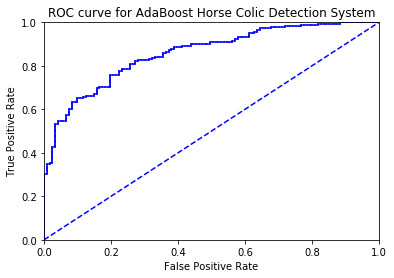

The Area Under the Curve is:  0.8582969635063604


In [98]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

## 6. Sklearn实现

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

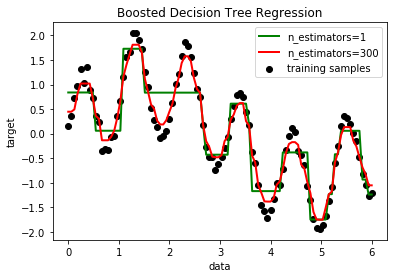

y--- <class 'numpy.float64'> 100 [0.16243454 0.35506848 0.73293321 0.96056821]
y_1--- <class 'numpy.float64'> 100 [0.8381376 0.8381376 0.8381376 0.8381376]
y_2--- <class 'numpy.float64'> 100 [0.44598854 0.44598854 0.49302021 0.80710121]
y_scores--- <class 'numpy.float64'> 4 [0.1  0.4  0.35 0.8 ]
0.75


In [101]:
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

plt.figure()
plt.scatter(X, y, c='k', label="training samples")
plt.plot(X, y_1, c='g', label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c='r', label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

print('y---', type(y[0]), len(y), y[:4])
print('y_1---', type(y_1[0]), len(y_1), y_1[:4])
print('y_2---', type(y_2[0]), len(y_2), y_2[:4])

y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
print('y_scores---', type(y_scores[0]), len(y_scores), y_scores)
print(metrics.roc_auc_score(y_true, y_scores))